# HACKATHON '23 - BYTE BUSTERS - ML

## Import data

In [32]:
from backtesting.test import EURUSD, GOOG

data = EURUSD.copy()
data

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


In [33]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20200101'
TO_DATE='20221231'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

df = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_21079/1567309444.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
/tmp/ipykernel_21079/1567309444.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [34]:
df.tail()


,open,high,low,close,volume
datetime,,,,,
2022-12-30 17:00:00,1.069685,1.071160,1.069635,1.071100,42670.809678
2022-12-30 18:00:00,1.071120,1.071335,1.070070,1.070250,63832.159551
2022-12-30 19:00:00,1.070255,1.070955,1.069530,1.069995,40780.469731
2022-12-30 20:00:00,1.069985,1.070835,1.069240,1.070550,27173.242018
2022-12-30 21:00:00,1.070575,1.070735,1.069910,1.070680,23531.349755


## ML Training

#### Helper functions

In [35]:
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

#### Design features for the model to train on

In [36]:
# Price derived
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicators
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

#### Create Matrix

In [37]:
import numpy as np

def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

### Testing Model

#### Setup Model & Train

Classification accuracy:  0.4210960032962505


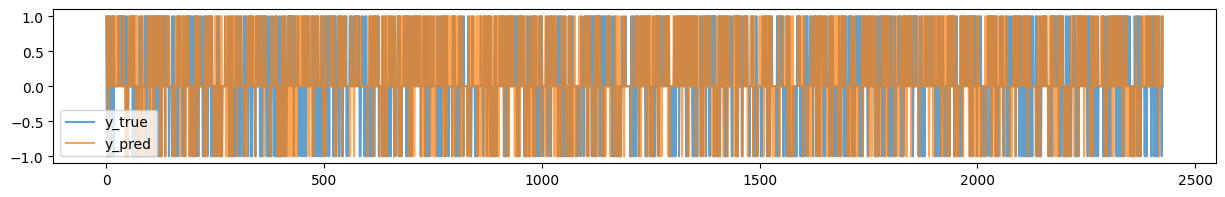

In [38]:
from sklearn.neighbors import KNeighborsClassifier#### Setup Model & Train
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

Classification accuracy:  0.48372476308199425


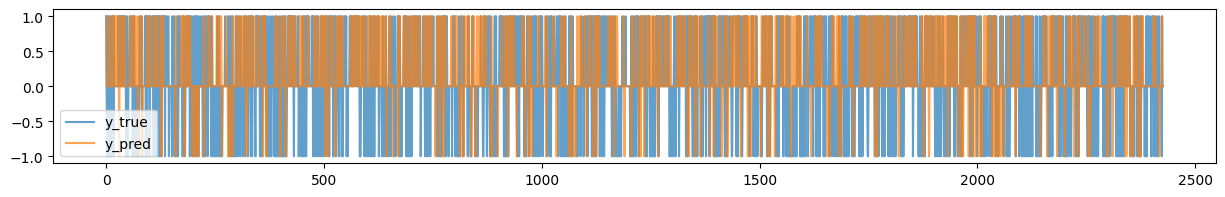

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(30)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

## Strategy

In [40]:
%%time

from backtesting import Backtest, Strategy

class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 20
    n2 = 45
    n3 = 200
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma3 = self.I(SMA, self.data.Close, self.n3)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

CPU times: user 42 µs, sys: 9 µs, total: 51 µs
Wall time: 56.3 µs


## Backtesting

In [41]:
bt = Backtest(, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
stats

NameError: name 'crossover' is not defined

In [ ]:
bt.plot()

/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1309', ...)

Opening in existing browser session.


In [ ]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()